### Notebook for the epithelial label transfer of Reference epithelial dataset (GCA + Kong + Wang + Smillie) to rest of epithelial cells from GCA using `scANVI`

- **Developed by:** Anna Maguza
- **Institute of Computational Biology - Computational Health Department - Helmholtz Munich**
- 11th April 2022

### Load required modules

In [2]:
import sys
import scvi
import torch
import anndata
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import numpy as np
import scipy as sp
import pandas as pd
import scanpy as sc
import numpy.random as random


from umap import UMAP
import warnings; warnings.simplefilter('ignore')

import matplotlib.pyplot as plt

/Users/anna.maguza/miniconda3/envs/scvi_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 0
/Users/anna.maguza/miniconda3/envs/scvi_env/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/Users/anna.maguza/miniconda3/envs/scvi_env/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/Users/anna.maguza/miniconda3/envs/scvi_env/lib/python3.9/site-packages/flax/struct.py:132: FutureWarnin

In [3]:
%matplotlib inline
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

In [4]:
torch.cuda.is_available()

False

In [5]:
torch.set_float32_matmul_precision('medium')

In [6]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.8.0
scanpy      1.9.3
-----
PIL                         9.4.0
absl                        NA
appnope                     0.1.2
asttokens                   NA
attr                        22.2.0
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
brotli                      NA
certifi                     2022.12.07
cffi                        1.15.1
charset_normalizer          2.1.1
chex                        0.1.6
colorama                    0.4.6
comm                        0.1.2
contextlib2                 NA
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
defusedxml                  0.7.1
docrep                      0.3.2
entrypoints                 0.4
executing                   0.8.3
flax                        0.6.1
fsspec                      2023.3.0
h5py                        3.8.0
hypergeom_uf

In [7]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 2,
)

In [8]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

### Read in Reference object

In [21]:
#Save the anndata_subset object - local machine path
reference_input = '/Users/anna.maguza/Desktop/Data/Processed_datasets/Geosketch_subsets/Epithelial_cells/Epithelial_cells_Geosketch_subset_reference_with_Kong.h5ad'
reference = sc.read_h5ad(reference_input)
reference.X

<72662x23616 sparse matrix of type '<class 'numpy.float32'>'
	with 159951157 stored elements in Compressed Sparse Row format>

In [22]:
reference.obs['seed_labels'] = reference.obs['Cell States GCA'].copy()

### Read query object

In [23]:
#Save the anndata_subset object - local machine path
query_input = '/Users/anna.maguza/Desktop/Data/Processed_datasets/Geosketch_subsets/Epithelial_cells/Epithelial_cells_Geosketch_subset_query_with_Kong.h5ad'
query = sc.read_h5ad(reference_input)
query.X

<72662x23616 sparse matrix of type '<class 'numpy.float32'>'
	with 159951157 stored elements in Compressed Sparse Row format>

In [24]:
query.obs['seed_labels'] = 'Unknown'

In [25]:
# Concatenate reference and query
adata = reference.concatenate(query, batch_key = 'dataset', batch_categories = ['reference', 'query'])

In [15]:
del reference, query

#### Batch Preparation


In [27]:
# Replace the "nan" or "NaN" string in the Sample_ID column
adata.obs['Sample_ID'] = adata.obs.apply(
    lambda row: row['Sample_ID'] if row['Sample_ID'].lower() != "nan" else
    (row['Donor_ID'] + '_' + str(row['Age']) + '_' + row['Region code'] + '_' + str(row['Fraction'])),
    axis=1
)

In [28]:
adata.obs['Donor_ID'] = adata.obs['Donor_ID'].astype('str')
adata.obs['Age'] = adata.obs['Age'].astype('str')
adata.obs['Region code'] = adata.obs['Region code'].astype('str')
adata.obs['Fraction'] = adata.obs['Fraction'].astype('str')

In [29]:
adata.obs['Sample_ID'] = adata.obs['Sample_ID'].where(
    pd.notna(adata.obs['Sample_ID']),
    adata.obs['Donor_ID'] + '_' + adata.obs['Age'].astype(str) + '_' +
    adata.obs['Region code'] + '_' + adata.obs['Fraction'].astype(str)
)

In [30]:
df = adata.obs['Sample_ID'].value_counts()

### Select HVGs

In [31]:
X_is_raw(adata)

True

In [32]:
sc.pp.log1p(adata)

In [33]:
adata.layers['counts'] = adata.X.copy()

In [34]:
X_is_raw(adata)

False

In [35]:
sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 3000,
    layer = "counts",
    batch_key = "Donor_ID",
    subset = True,
    span = 1
)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


: 

: 

In [16]:
adata_raw = adata.copy()
adata.layers['counts'] = adata.X.copy()

### Transfer of annotation with scANVI

In [17]:
scvi.model.SCVI.setup_anndata(adata, batch_key = 'Donor_ID', labels_key = "seed_labels", layer = 'counts')

In [18]:
scvi_model = scvi.model.SCVI(adata, n_latent = 50, n_layers = 3, dispersion = 'gene-batch', gene_likelihood = 'nb')

In [19]:
scvi_model.train(150)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 150/150: 100%|██████████| 150/150 [7:52:05<00:00, 183.43s/it, loss=6.01e+03, v_num=1]  

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 150/150: 100%|██████████| 150/150 [7:52:05<00:00, 188.83s/it, loss=6.01e+03, v_num=1]


### Label transfer with `scANVI` 

In [20]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, 'Unknown')

In [21]:
scanvi_model.train(50)

INFO     Training for 50 epochs.                                                                                   


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 50/50: 100%|██████████| 50/50 [3:55:21<00:00, 275.57s/it, loss=6.03e+03, v_num=1]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████| 50/50 [3:55:21<00:00, 282.43s/it, loss=6.03e+03, v_num=1]


In [22]:
adata.obs["C_scANVI"] = scanvi_model.predict(adata)

- Extract latent representation

In [23]:
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata)

- Visualise corrected dataset

In [24]:
sc.pp.neighbors(adata, use_rep = "X_scANVI", n_neighbors = 50, metric = 'minkowski')
sc.tl.umap(adata, min_dist = 0.2, spread = 2, random_state = 1712)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:30)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:20)


In [25]:
adata.obs

Cell Type batch  \
cell_id                                                          
ACGCCAGCAGCCAATT-1-4918STDY7333456-reference  Epithelial   GCA   
ACGCCGAGTGAGGCTA-1-4918STDY7333456-reference  Epithelial   GCA   
ACGCCGAGTTCCCGAG-1-4918STDY7333456-reference  Epithelial   GCA   
ACGGGCTCACCAGGTC-1-4918STDY7333456-reference  Epithelial   GCA   
ACGGGTCGTAGCAAAT-1-4918STDY7333456-reference  Epithelial   GCA   
...                                                  ...   ...   
N110.LPA.TCGGGACGTCAACTGT-query                Stem Cell   GCA   
N110.LPA.TGAGCATTCCAGTAGT-query                Stem Cell   GCA   
N110.LPA.TGGCCAGAGAGGACGG-query                Stem Cell   GCA   
N110.LPA.TTCTTAGCAGTCCTTC-query                Stem Cell   GCA   
N110.LPA.TTTATGCAGACTACAA-query                Stem Cell   GCA   

                                                       Sample_ID n_genes  \
cell_id                                                                    
ACGCCAGCAGCCAATT-1-4918STDY7333456-reference  T036-TIL-SC-EPCAMP    2288   
ACGCCGAGTGAGGCTA-1-4918STDY7333456-reference  T036-TIL-SC-EPCAMP    1244   
ACGCCGAGTTCCCGAG-1-4918STDY7333456-reference  T036-TIL-SC-EPCAMP    3431   
ACGGGCTCACCAGGTC-1-4918STDY7333456-reference  T036-TIL-SC-EPCAMP     572   
ACGGGTCGTAGCAAAT-1-4918STDY7333456-reference  T036-TIL-SC-EPCAMP    1095   
...                                                          ...     ...   
N110.LPA.TCGGGACGTCAACTGT-query                         N110.LPA    1232   
N110.LPA.TGAGCATTCCAGTAGT-query                         N110.LPA    3181   
N110.LPA.TGGCCAGAGAGGACGG-query                         N110.LPA    4380   
N110.LPA.TTCTTAGCAGTCCTTC-query                         N110.LPA    3634   
N110.LPA.TTTATGCAGACTACAA-query                         N110.LPA    2094   

                                             n_counts Chem  Location Donor_ID  \
cell_id                                                                         
ACGCCAGCAGCCAATT-1-4918STDY7333456-reference   8606.0  nan  SmallInt     T036   
ACGCCGAGTGAGGCTA-1-4918STDY7333456-reference   3152.0  nan  SmallInt     T036   
ACGCCGAGTTCCCGAG-1-4918STDY7333456-reference  14716.0  nan  SmallInt     T036   
ACGGGCTCACCAGGTC-1-4918STDY7333456-reference   1283.0  nan  SmallInt     T036   
ACGGGTCGTAGCAAAT-1-4918STDY7333456-reference   2194.0  nan  SmallInt     T036   
...                                               ...  ...       ...      ...   
N110.LPA.TCGGGACGTCAACTGT-query                  4384  nan        LP     N110   
N110.LPA.TGAGCATTCCAGTAGT-query                 15655  nan        LP     N110   
N110.LPA.TGGCCAGAGAGGACGG-query                 26921  nan        LP     N110   
N110.LPA.TTCTTAGCAGTCCTTC-query                 22468  nan        LP     N110   
N110.LPA.TTTATGCAGACTACAA-query                 11357  nan        LP     N110   

                                             Layer     Cell States  ...  \
cell_id                                                             ...   
ACGCCAGCAGCCAATT-1-4918STDY7333456-reference   nan  Stem_Cells_GCA  ...   
ACGCCGAGTGAGGCTA-1-4918STDY7333456-reference   nan     Goblet cell  ...   
ACGCCGAGTTCCCGAG-1-4918STDY7333456-reference   nan  Stem_Cells_GCA  ...   
ACGGGCTCACCAGGTC-1-4918STDY7333456-reference   nan  L cells (PYY+)  ...   
ACGGGTCGTAGCAAAT-1-4918STDY7333456-reference   nan            Tuft  ...   
...                                            ...             ...  ...   
N110.LPA.TCGGGACGTCAACTGT-query                nan  Stem_Cells_ext  ...   
N110.LPA.TGAGCATTCCAGTAGT-query                nan  Stem_Cells_ext  ...   
N110.LPA.TGGCCAGAGAGGACGG-query                nan  Stem_Cells_ext  ...   
N110.LPA.TTCTTAGCAGTCCTTC-query                nan  Stem_Cells_ext  ...   
N110.LPA.TTTATGCAGACTACAA-query                nan  Stem_Cells_ext  ...   

                                             UniqueCell_ID  Age Region code  \
cell_id                                                                       
ACGCCAGCAGC

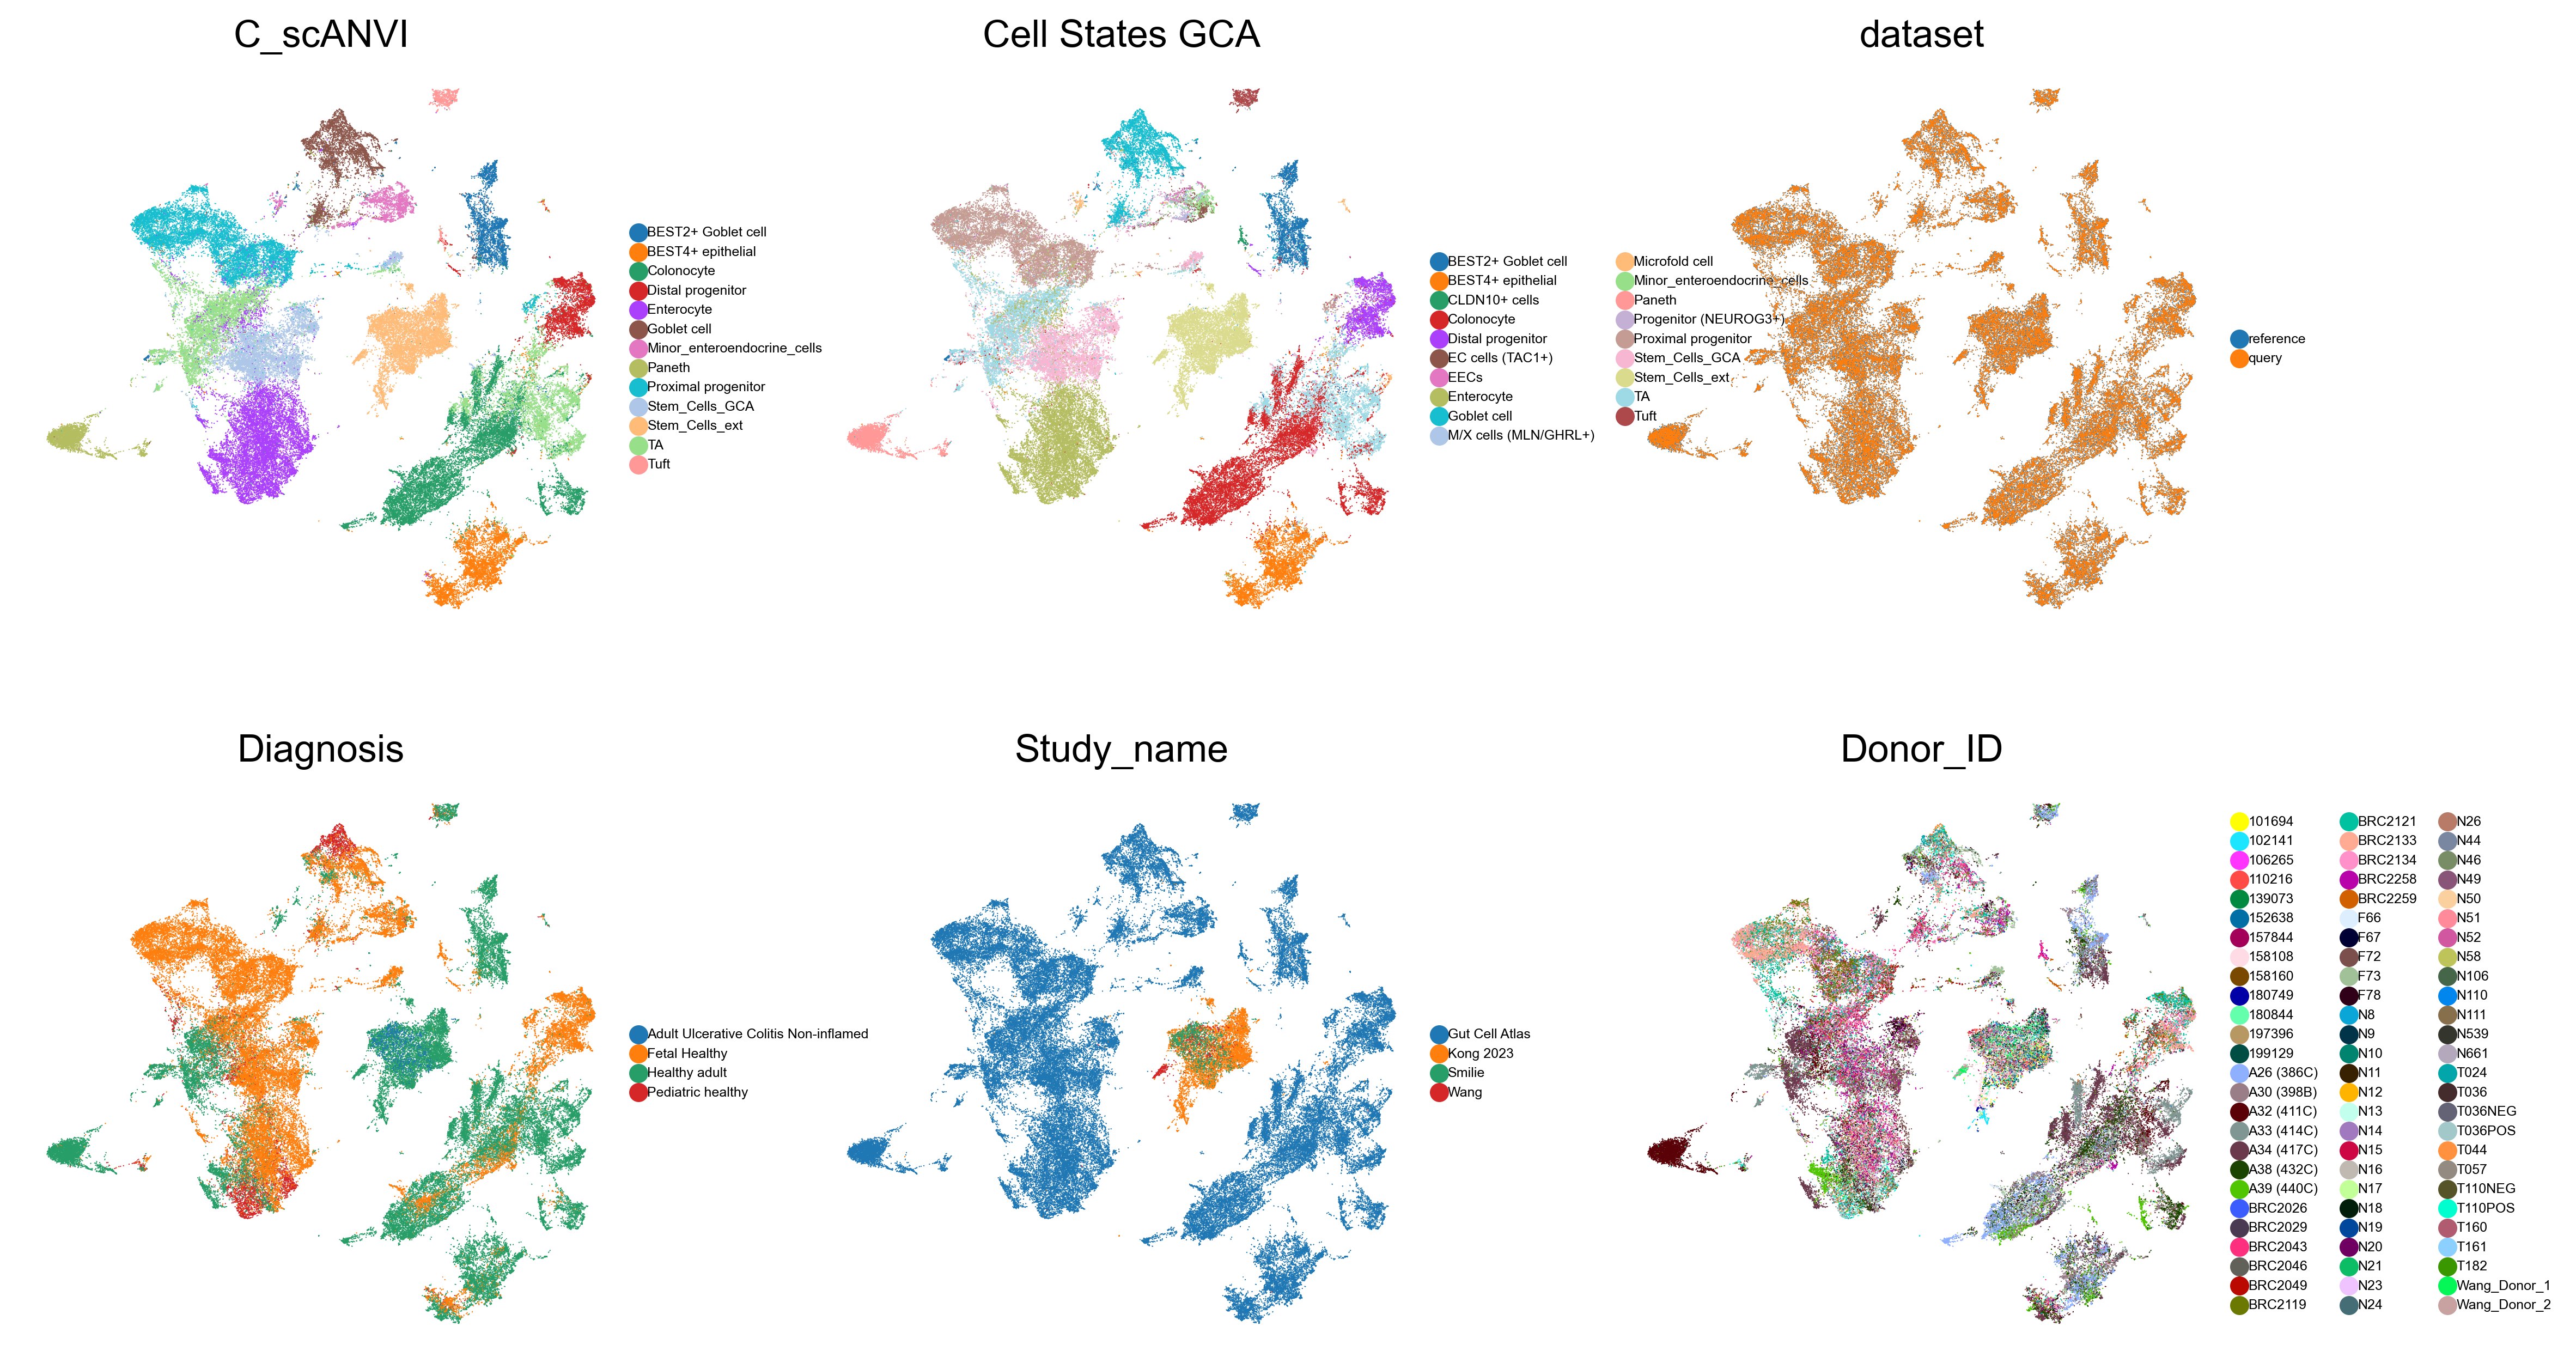

In [26]:
sc.pl.umap(adata, frameon = False, color = ['C_scANVI', 'Cell States GCA', 'dataset', 'Diagnosis', 'Study_name', 'Donor_ID'], size = 0.6, legend_fontsize = 5, ncols = 3)

In [27]:
#Write anndata object to file - local machine path
adata.write_h5ad('/Users/anna.maguza/Desktop/Data/Processed_datasets/post_SCANVI/Epithelial/Epithelial_cells_after_scanvi_with_Kong.h5ad')

### Models Validation

In [ ]:
input_file = '/lustre/groups/talaveralopez/workspace/anna.maguza/Processed_datasets/expi_map/Epithelial_cells_after_scanvi2.h5ad'
output_file = '/lustre/groups/talaveralopez/workspace/anna.maguza/Processed_datasets/expi_map/Epithelial_cells_after_scanvi_output.h5ad'
adata = sc.read_h5ad(input_file)

In [28]:
adata.obs['C_scANVI'].value_counts()

TA                             21002
Colonocyte                     20254
Enterocyte                     19718
Proximal progenitor            17586
Stem_Cells_ext                 13802
Stem_Cells_GCA                 13038
BEST4+ epithelial               9116
Goblet cell                     8168
Distal progenitor               6094
BEST2+ Goblet cell              5910
Paneth                          5354
Minor_enteroendocrine_cells     3616
Tuft                            1666
Name: C_scANVI, dtype: int64

In [29]:
adata.obs['Cell States GCA'].value_counts()

TA                             20000
Colonocyte                     20000
Enterocyte                     20000
Proximal progenitor            17160
Stem_Cells_ext                 13818
Stem_Cells_GCA                 13818
BEST4+ epithelial               8800
Goblet cell                     7930
BEST2+ Goblet cell              5850
Paneth                          5822
Distal progenitor               5550
Tuft                            1376
Minor_enteroendocrine_cells     1258
Microfold cell                   860
EC cells (TAC1+)                 774
EECs                             742
Progenitor (NEUROG3+)            584
M/X cells (MLN/GHRL+)            536
CLDN10+ cells                    446
Name: Cell States GCA, dtype: int64

Text(0, 0.5, 'Observed')

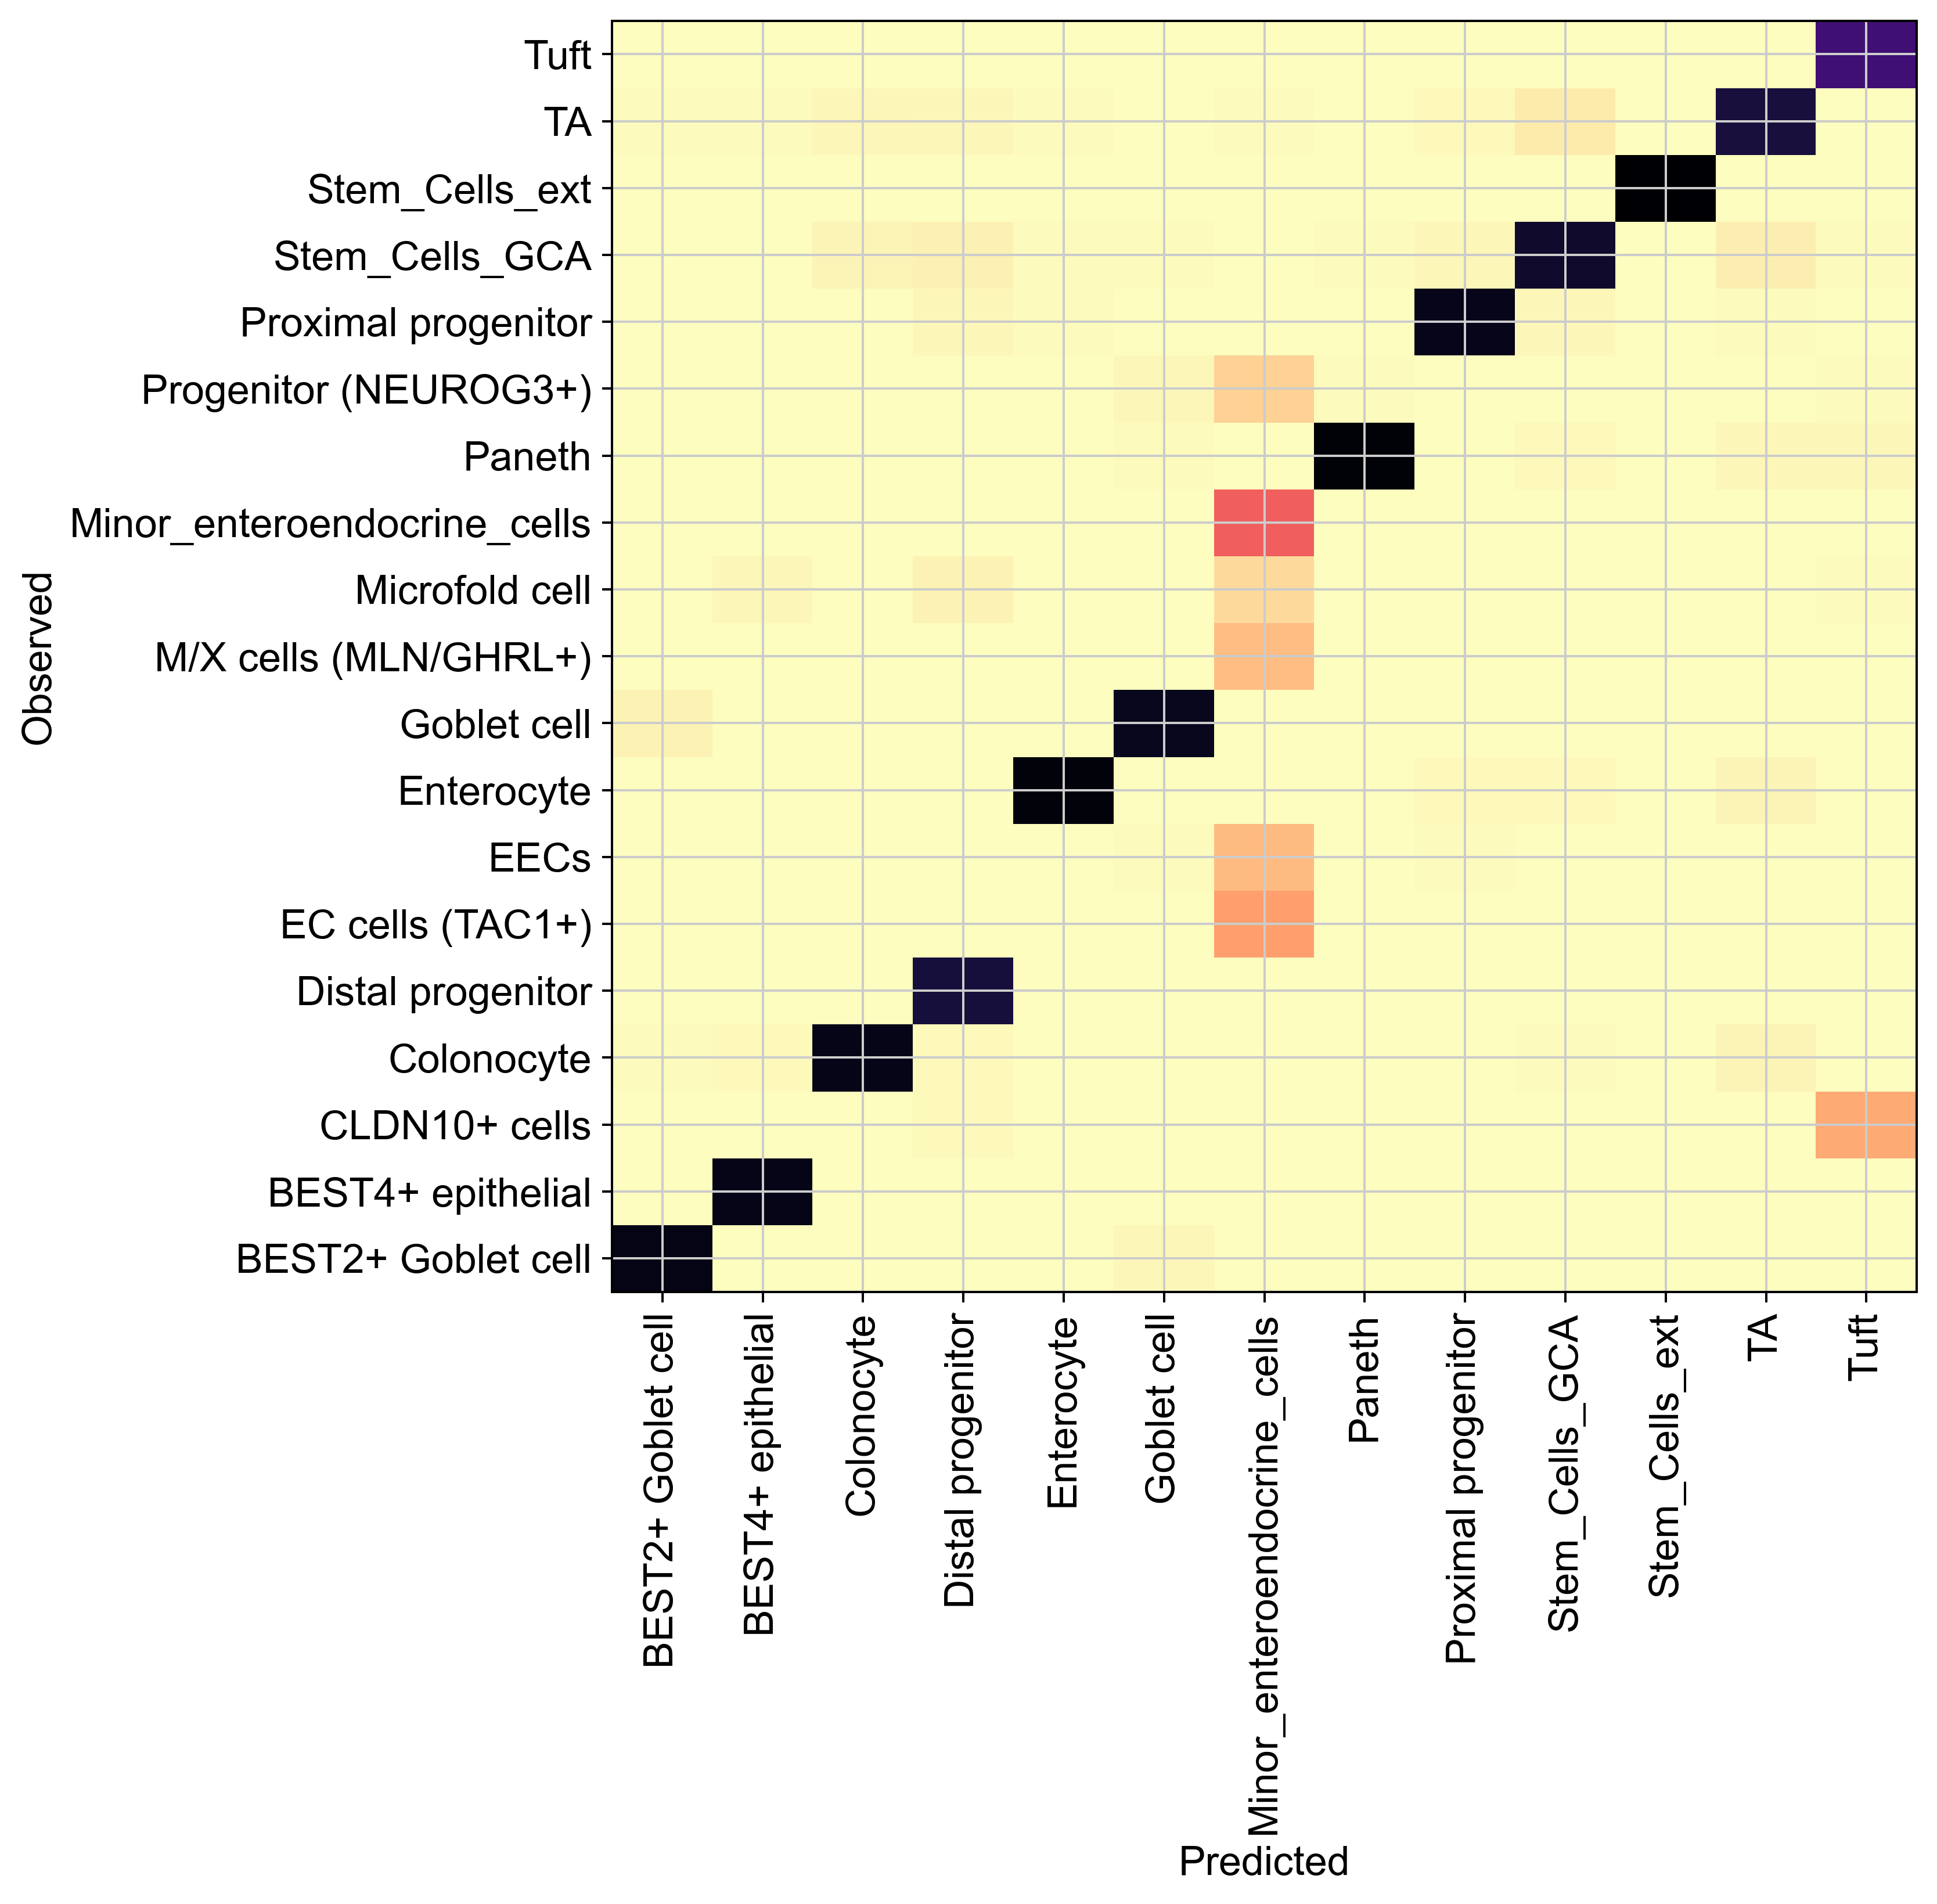

In [30]:
#Validation of the clusters
df = adata.obs.groupby(['Cell States GCA', "C_scANVI"]).size().unstack(fill_value=0)
norm_df = df / df.sum(axis=0)

plt.figure(figsize=(8, 8))
_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")

In [33]:
#Calculate accuracy
print(f"Acc: {np.mean(adata.obs['Cell States GCA'].cat.codes == adata.obs.C_scANVI.cat.codes)}")

Acc: 0.10285981668547521
